In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import hmmlearn.hmm as hmm

In [3]:
transition_matrix = np.loadtxt('../p1/DTMC.csv', delimiter=',')

In [4]:
#Steady state
val, vec  = np.linalg.eig(transition_matrix)
#find index of egenvalue 1
index = np.where(val - 1 < 0.001)[0][0]
steady_state = (vec.T[index] / np.sum(vec.T[index])).real
steady_state

array([0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.01754386,
       0.01754386, 0.01754386])

In [5]:
def random_walk(transition_matrix, steady_state, length=100):
    num_states = len(steady_state)
    current_state = np.random.choice(np.arange(num_states), p=steady_state)
    walk = [current_state]
    for i in range(length-1):
        current_state = np.random.choice(np.arange(num_states), p=transition_matrix[current_state])
        walk.append(current_state)
    return walk

In [6]:
num_walks = 1000
walk_length = 100
walks = np.array([random_walk(transition_matrix, steady_state, walk_length) for _ in range(num_walks)])
walks

array([[54, 24,  0, ..., 48, 15, 17],
       [28, 31, 10, ..., 10,  5, 44],
       [18, 54, 21, ..., 33, 54, 45],
       ...,
       [34, 35, 56, ..., 38, 28, 31],
       [19, 55, 56, ..., 11,  9,  3],
       [48, 49, 16, ..., 19, 55, 45]])

In [7]:
gHMM = hmm.GaussianHMM(len(steady_state), random_state=42, n_iter=1000)
gHMM.fit(walks)


GaussianHMM(n_components=57, n_iter=1000, random_state=42)

Number of learned transition probabilities that are not both zero and equal

In [8]:
((transition_matrix == gHMM.transmat_) & ((transition_matrix != 0) | (gHMM.transmat_ != 0))).sum()

0

In [9]:
(transition_matrix != 0).sum()

420

In [10]:
(gHMM.transmat_ != 0).sum()

2150

In [11]:
((transition_matrix != 0) | (gHMM.transmat_ != 0)).sum()

2282

In [12]:
p = 0.05
((abs(transition_matrix - gHMM.transmat_) < p) & ((transition_matrix != 0) | (gHMM.transmat_ != 0))).sum()

1747

In [13]:
np.savetxt('transition.csv', gHMM.transmat_, delimiter=',')
np.savetxt('transition_error.csv', transition_matrix - gHMM.transmat_, delimiter=',')
np.savetxt('means.csv', gHMM.means_, delimiter=',')

In [14]:
cHMM = hmm.CategoricalHMM(len(steady_state), random_state=42)
cHMM.fit(walks)

CategoricalHMM(n_components=57,
               random_state=RandomState(MT19937) at 0x162C71B40)

In [15]:
((transition_matrix == cHMM.transmat_) & ((transition_matrix != 0) | (cHMM.transmat_ != 0))).sum()

0

In [16]:
(transition_matrix != 0).sum()

420

In [17]:
(cHMM.transmat_ != 0).sum()

3249

In [18]:
((transition_matrix != 0) | (cHMM.transmat_ != 0)).sum()

3249

In [19]:
p = 0.05
((abs(transition_matrix - cHMM.transmat_) < p) & ((transition_matrix != 0) | (cHMM.transmat_ != 0))).sum()

2887

In [20]:
cHMM.predict([[0,1,2,3]])

array([10, 48, 10, 50])

In [21]:
cHMM.emissionprob_.shape

(57, 57)

In [23]:
import pickle
import gzip

with gzip.open("cHMM.pickle.gz", "w") as f:
    pickle.dump(cHMM, f)

In [187]:
import pickle
import gzip
with gzip.open("cHMM.pickle.gz", "r") as f:
    cHMM = pickle.load(f)
# Steady state
val, vec  = np.linalg.eig(cHMM.transmat_)
#find index of egenvalue 1
index = np.argmin(abs(val - 1))
steady_state = (vec.T[index] / np.sum(vec.T[index])).real

States = observations  
Optimal: Emission Matrix = Diagional  
Gelernt: Emission Matrix ~= Diagional  

# Task 1.2

In [188]:
def obs_path_probability_3(o1, o2, o3=None):
    p_sum = 0
    # pESo1 = Probability of emission of component one is operational
    for component_index1, pESo1 in enumerate(cHMM.emissionprob_[:,o1].flatten()):
        for component_index2, pT1 in enumerate(cHMM.transmat_[component_index1]):
            pESd1 = cHMM.emissionprob_[component_index2, o2]
            if o3 is None:
                p_sum += pESo1 * pT1 * pESd1 * steady_state[component_index1]
                continue
            for component_index3, pT2 in enumerate(cHMM.transmat_[component_index2]):
                pESo1count2 = cHMM.emissionprob_[component_index3, o3]
                p_sum += pESo1 * pT1 * pESd1 * pT2 * pESo1count2 * steady_state[component_index1]
    return p_sum

def obs_path_max_prob_states(o1, o2, o3=None):
    p_max = 0
    # pESo1 = Probability of emission of component one is operational
    for component_index1, pESo1 in enumerate(cHMM.emissionprob_[:,o1].flatten()):
        for component_index2, pT1 in enumerate(cHMM.transmat_[component_index1]):
            pESd1 = cHMM.emissionprob_[component_index2, o2]
            if o3 is None:
                p = pESo1 * pT1 * pESd1 * steady_state[component_index1]
                if p_max < p:
                    path = [component_index1, component_index2]
                    p_max = p
                continue
            for component_index3, pT2 in enumerate(cHMM.transmat_[component_index2]):
                pESo1count2 = cHMM.emissionprob_[component_index3, o3]
                p = pESo1 * pT1 * pESd1 * pT2 * pESo1count2 * steady_state[component_index1]
                if p_max < p:
                    path = [component_index1, component_index2, component_index3]
                    p_max = p
    return path, p_max

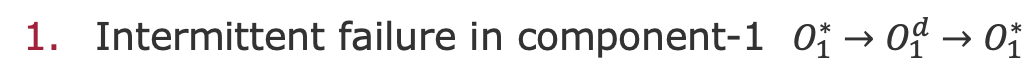

In [189]:
# All states that emit an observation that regards component one
So1 = np.where(cHMM.emissionprob_[:,0].flatten() > 0)[0]

In [190]:
So1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56])

In [191]:
obs_path_probability_3(0,1,0), obs_path_max_prob_states(0,1,0)

(5.274022436408879e-05, ([21, 54, 21], 4.636734208189061e-05))

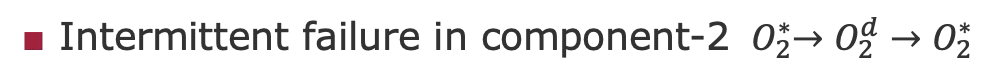

In [192]:
obs_path_probability_3(3,4,3), obs_path_max_prob_states(3,4,3)

(9.582404553639613e-05, ([50, 23, 50], 3.794636923213033e-05))

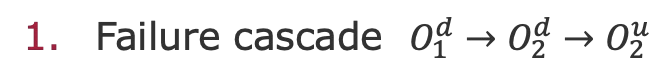

In [193]:
obs_path_probability_3(1,4,5), obs_path_max_prob_states(1,4,5)

(1.596216344687159e-07, ([48, 27, 56], 5.0699920919803975e-08))

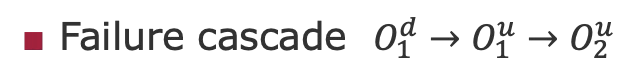

In [194]:
obs_path_probability_3(1,2,5), obs_path_max_prob_states(1,2,5)

(1.3840618202800932e-07, ([42, 10, 50], 5.605186607397443e-08))

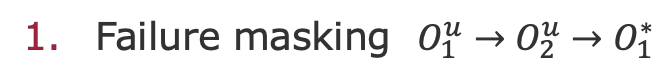

In [195]:
obs_path_probability_3(2,5,0), obs_path_max_prob_states(2,5,0)

(4.0503053843784e-10, ([10, 42, 21], 1.473063587558488e-10))

# Task 2.2

In [196]:
while True:
    int_obs, int_states = cHMM.sample(n_samples=3, currstate=np.random.randint(0, 19) * 3)
    int_seq = int_obs.flatten()
    if int_seq[0] % 3 == 0 and int_seq[0] == int_seq[2] and (int_seq[0] == int_seq[1] - 1 or int_seq[0] == int_seq[1] - 2):
        break
while True:
    casc_obs, casc_states = cHMM.sample(n_samples=2, currstate=np.random.randint(0, 19) * 3)
    casc_seq = casc_obs.flatten()
    if casc_seq[0] % 3 != 0 and casc_seq[1] % 3 != 0 and (casc_seq[1] // 3) != (casc_seq[0] // 3):
        break
while True:
    mask_obs, mask_states = cHMM.sample(n_samples=3, currstate=np.random.randint(0, 19) * 3)
    mask_seq = mask_obs.flatten()
    if mask_seq[0] % 3 != 0 and mask_seq[1] % 3 != 0 and (mask_seq[1] // 3) != (mask_seq[0] // 3) and mask_seq[2] % 3 == 0 and (mask_seq[2] // 3) == (mask_seq[0] // 3):
        break

In [197]:
int_seq, int_states

(array([27, 28, 27]), array([45, 26, 11]))

In [198]:
obs_path_probability_3(*int_seq.tolist()), obs_path_max_prob_states(*int_seq.tolist())

(0.00047264672912850834, ([45, 26, 11], 0.0001638409577923224))

In [199]:
casc_seq, casc_states

(array([31, 10]), array([30, 20]))

In [200]:
obs_path_probability_3(*casc_seq.tolist()), obs_path_max_prob_states(*casc_seq.tolist())

(0.005258168792234535, ([30, 20], 0.0019336664872138276))

In [201]:
mask_seq, mask_states

(array([10,  4,  9]), array([36, 27, 18]))

In [202]:
obs_path_probability_3(*mask_seq.tolist()), obs_path_max_prob_states(*mask_seq.tolist())

(0.0013637603579586444, ([36, 27, 18], 0.0013578478178016364))